In [1]:
import sys
print(sys.executable) 

/Users/drishtimannan/anaconda3/envs/LIDS/bin/python


In [2]:
import pandas as pd
import tifffile
import random
import numpy as np
import matplotlib.pyplot as plt

 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### Read the csv of the ground truth as a pandas dataframe. Here we are extracting centroid locations for all timepoints. This will be used to train and test LDA performance

In [3]:
#upload ground truth labels for generating training data for LDA
ground1=pd.read_csv('../dmannan1/LDA2/Substacks_with_SpineROIs/a1_tp1.csv')
ground2 = pd.read_csv('../dmannan1/LDA2/Substacks_with_SpineROIs/a2_tp2.csv')
ground3 = pd.read_csv("../dmannan1/LDA2/Substacks_with_SpineROIs/a3_tp3.csv")
ground4 = pd.read_csv('../dmannan1/LDA2/Substacks_with_SpineROIs/a4_tp4.csv')

print(len(ground1))
print(len(ground2))
print(len(ground3))
print(len(ground4))


222
195
218
207


In [4]:
### Change the panadas dataframe to numpy array and arrange the columns as Z,Y,X

ground_truth1 = np.asarray(ground1[['Z', 'Y', 'X']])
ground_truth2 = np.asarray(ground2[['Z', 'Y', 'X']])
ground_truth3 = np.asarray(ground3[['Z', 'Y', 'X']])
ground_truth4 = np.asarray(ground4[['Z', 'Y', 'X']])



### The csv given, the z-slices range from 1-16, but need to range from 0-15.

In [5]:
ground_truth1[:,0] = ground_truth1[:,0] - 1 ## -1 to make sure the dummy array index and ground_truth match
ground_truth2[:,0] = ground_truth2[:,0] - 1
ground_truth3[:,0] = ground_truth3[:,0] - 1
ground_truth4[:,0] = ground_truth4[:,0] - 1

# print(ground_truth1)
# print(ground_truth2)
# print(ground_truth3)
# print(ground_truth4)
print(len(ground_truth1))
print(len(ground_truth2))
print(len(ground_truth3))
print(len(ground_truth4))

222
195
218
207


### We make sure that synapse cubes do not overlap with non-synapses in training and testing set
Extract centroid locations of known synapses and mark an area around the synapses 

In [6]:
dummy_array1 = np.zeros((16, 359, 359))##to keep track of the centroids and the area around it to make sure training 
#set doesn't have any overlapping areas. We need 359x359 by 16 arrays. In here provide the dimensions of tiff file 
# you are working with in z,y,x format
dummy_array2 = np.zeros((16, 359, 359))
dummy_array3 = np.zeros((16, 359, 359))
dummy_array4 = np.zeros((16, 359, 359))

### Finally need to extract non-synapses that don't overlap with synapse locations or their cubes

In [7]:
def centroid_cubes(size_cube, array, centroid_locations): ##need to make cubes around our synapses to ensure they don't overlap with
##non-synapses

    sin=0
    for z, y ,x in zip(centroid_locations[:,0], centroid_locations[:,1], centroid_locations[:,2]):
        if x-size_cube<0 or x+size_cube>358 or y-size_cube<0 or y+size_cube>358:
            continue
        for l in range(y-size_cube,y+size_cube): ## 4.84 microns cubed cube is formed by a 22x22 rectangle around the centroid locations
            for m in range(x-size_cube,x+size_cube):
                array[z][l][m] = 1
        sin = sin+1


    return  array, sin


In [8]:
a1, s1 =centroid_cubes(11,dummy_array1,ground_truth1)
a2, s2 =centroid_cubes(11,dummy_array2,ground_truth2)
a3, s3 =centroid_cubes(11,dummy_array3,ground_truth3)
a4, s4 =centroid_cubes(11,dummy_array4,ground_truth4)
print(np.sum(a1))
print(np.sum(a2))
print(np.sum(a3))
print(np.sum(a4))
print(s1)
print(s2)
print(s3)
print(s4)

76411.0
68901.0
80455.0
81192.0
187
163
190
196


### In the above cell we had filled our dummy arrays with ones where there is a synapse and cubes around them. In the next cell we are trying to find non-synapse centroids from remaining points in our dummy arrays

In [9]:
def finding_non_synapses(size_cube, array2, sin):
    num = 0
    z_loc = []
    y_loc = []
    x_loc = []

    while num < sin:


        x_ns = np.random.randint(size_cube,359-size_cube)##discarding points within 5 pixels from boundary of 359x359x16
    ##pixels because want to generate a 4.84 cube for mean intensity. Also, x and y values range from 0-358.
        y_ns = np.random.randint(size_cube,359-size_cube)
        z_ns = np.random.randint(0,16)
        if array2[z_ns][y_ns][x_ns] ==1 or array2[z_ns][y_ns-size_cube][x_ns-size_cube]==1 or array2[z_ns][y_ns+size_cube][x_ns+size_cube]==1 or array2[z_ns][y_ns-size_cube][x_ns+size_cube]==1 or array2[z_ns][y_ns+size_cube][x_ns-size_cube]==1:
            continue
        z_loc.append(z_ns)
        y_loc.append(y_ns)
        x_loc.append(x_ns)
        for s in range(y_ns-size_cube,y_ns+size_cube): ## 4.84 microns cubed cube is formed by a 10x10 rectangle around the centroid locations
            for p in range(x_ns-size_cube,x_ns+size_cube):
                 array2[z_ns][s][p] = 1
        num += 1
        








    return np.asarray((z_loc,y_loc,x_loc)).T


In [10]:
non_syn1 = finding_non_synapses(11,a1,s1)
print(non_syn1.shape)

non_syn2 = finding_non_synapses(11,a2,s2)
print(non_syn2.shape)

non_syn3 = finding_non_synapses(11,a3,s3)
print(non_syn3.shape)

non_syn4 = finding_non_synapses(11,a4,s4)
print(non_syn4.shape)


(187, 3)
(163, 3)
(190, 3)
(196, 3)


### Read the image tiff stack 
Give the correct paths to the four timepoints image files

In [11]:
im1 = tifffile.imread('../dmannan1/LDA2/Substacks_with_SpineROIs/R04_tp1_substack (17-32).tif')
im2 = tifffile.imread('../dmannan1/LDA2/Substacks_with_SpineROIs/R04_tp2_substack (17-32).tif')
im3 = tifffile.imread('../dmannan1/LDA2/Substacks_with_SpineROIs/R04_tp3_substack (19-34).tif')
im4 = tifffile.imread('../dmannan1/LDA2/Substacks_with_SpineROIs/R04_tp4_substack (20-35).tif')


### Finally finding the mean intensity of the cubes around the centroids generated

In [12]:
def generating_intensity(cube_size, samples, image, sin):
    all_intensity = []
    b = 0


    for z, y, x in zip(samples[:,0], samples[:,1], samples[:,2]):##take the z,x,y locations to iterate over
        intensity = []
        if x-cube_size<0 or x+cube_size>358 or y-cube_size<0 or y+cube_size>358:
            continue



        for l in range(y-cube_size,y+cube_size): ## 1 microns cubed cube is formed by a 22x22 rectangle around the centroid locations
            for m in range(x-cube_size,x+cube_size):
                intensity.append(image[z,l,m])

        mean_intensity = np.mean(intensity)
        all_intensity.append(mean_intensity)
        b = b+1
            



    return np.array(all_intensity).reshape((sin,1)) #, b

### Generating intensities for synapses and non-synapses

In [13]:
### First we'll generate synapse intensities:

syn_in1 = generating_intensity(11,ground_truth1,im1,s1)
print(syn_in1.shape)


syn_in2 = generating_intensity(11,ground_truth2,im2,s2)

print(syn_in2.shape)


syn_in3 = generating_intensity(11,ground_truth3,im3,s3)

print(syn_in3.shape)


syn_in4  = generating_intensity(11,ground_truth4,im4,s4)

print(syn_in4.shape)


(187, 1)
(163, 1)
(190, 1)
(196, 1)


In [14]:
## Now onto non-synapse intensities:

non_syn_in1  = generating_intensity(11,non_syn1,im1,s1)
print(non_syn_in1.shape)

non_syn_in2 = generating_intensity(11,non_syn2,im2,s2)

print(non_syn_in2.shape)

non_syn_in3 = generating_intensity(11,non_syn3,im3,s3)
print(non_syn_in3.shape)

non_syn_in4 = generating_intensity(11,non_syn4,im4,s4)

print(non_syn_in4.shape)




(187, 1)
(163, 1)
(190, 1)
(196, 1)


### Splitting the intensity arrays into training and testing:
Decide how much the intensity set will be split into testing and training set

In [15]:
def split_data (syn_intensity, non_syn_intensity, split):
    

    ##Choosing 50% of the data to be training set
    train_syn = syn_intensity[:int(split/2)]
    train_non_syn = non_syn_intensity[:int(split/2)]



    ##Testing set, take next rows 
    test_syn= syn_intensity[int(split/2):]
    test_non_syn = non_syn_intensity[int(split/2):]



    ### The final training set:
    train_data = np.vstack((train_syn, train_non_syn))
    test_data = np.vstack((test_syn, test_non_syn))
    ### The final label generation, synapses belong to class 1, non-synpases belong to class 0:
    train_labels = np.append(np.ones((len(train_syn))), np.zeros(len(train_non_syn)))
    
    return train_data, train_labels, test_data 


 

### Generating data set for the different time points

In [72]:
### Timepoint 1

train1, labels1, test1 = split_data(syn_in1, non_syn_in1, s1)

print(s1)
print(train1.shape)
print(labels1.shape)
print(test1.shape)
shp_1 = test1.shape[0]
print(shp_1)

187
(186, 1)
(186,)
(188, 1)
188


In [74]:
### Timepoint 2

train2, labels2, test2 = split_data(syn_in2, non_syn_in2, s2)

print(s2)
print(train2.shape)
print(labels2.shape)
print(test2.shape)
shp_2 = test2.shape[0]
print(shp_2)


163
(162, 1)
(162,)
(164, 1)
164


In [76]:
### Timepoint 3

train3, labels3, test3 = split_data(syn_in3, non_syn_in3, s3)

print(s3)
print(train3.shape)
print(labels3.shape)
print(test3.shape)

shp_3 = test3.shape[0]
print(shp_3)

190
(190, 1)
(190,)
(190, 1)
190


In [77]:
### Timepoint 4

train4, labels4, test4 = split_data(syn_in4, non_syn_in4, s4)

print(s4)
print(train4.shape)
print(labels4.shape)
print(test4.shape)

shp_4 = test4.shape[0]
print(shp_4)

196
(196, 1)
(196,)
(196, 1)
196


### Running LDA

In [92]:

def lda(train, labels, test, spl):
    b = []
    p = []
    r = []
    f = []
    prediction_int_overlays = []
    for i in np.arange(0.0, 1.0, 0.1):

        lda = LDA().fit(train, labels)
        probs_positive_class = lda.predict_proba(test)[:, 1]

        prediction = probs_positive_class > i
        prediction_int = prediction.astype(int)

        spl = int((test.shape[0])/2)
        true_pos = np.sum(prediction_int[:spl])
        false_pos = np.sum(prediction_int[spl:])
        false_neg = spl - true_pos 


        precision = (true_pos)/(true_pos + false_pos)


        recall = (true_pos)/(true_pos+false_neg)

        if precision and recall != 0:
            f1 = (2*precision*recall)/(precision + recall)
        else:
            f1 = 0 
        print(prediction_int, "Total wrong synapses:", false_neg, "Total wrong non-synapses:", false_pos, "Precision:",
             precision, "Recall:", recall, "F1", f1)
        p.append(precision)
        r.append(recall)
        b.append(i)
        f.append(f1)
        prediction_int_overlays.append(prediction_int)
        
    return b, p, r, f 

In [93]:
def stat_plot(threshold, pres, recall, f1):
    plt.plot(threshold, pres)
    plt.plot(threshold, recall)
    plt.plot(threshold, f1)
    plt.xlabel('Decision boundary threshold')
    plt.ylabel('Value of the labelled metric')

    plt.legend(['Precision', 'Recall', "F1"], loc='upper right')
    plt.title('Mean intensity of a 4.84 ${\mu}m^3$ cube and LDA performance by varying decision threshold')
    plt.show()

    
    

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1] Total wrong synapses: 0 Total wrong non-synapses: 94 Precision: 0.5 Recall: 1.0 F1 0.6666666666666666
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1
 1 1 0] Total wrong synapses: 0 Total wrong non-synapses: 79 Precision: 0.5433526011560693 Recall: 1.0 F1 0.7041198501872659
[1 1 1 1 1 1 1 

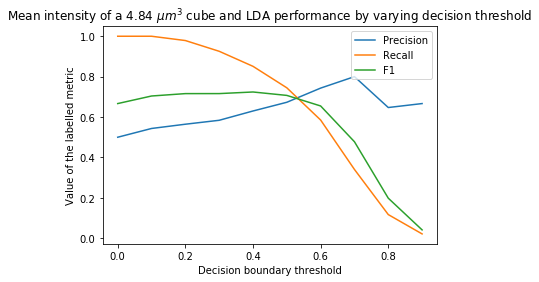

In [94]:
t1, p1, r1, f1 = lda(train1,labels1,test1, shp_1)
stat_plot(t1, p1, r1, f1)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] Total wrong synapses: 0 Total wrong non-synapses: 82 Precision: 0.5 Recall: 1.0 F1 0.6666666666666666
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] Total wrong synapses: 0 Total wrong non-synapses: 70 Precision: 0.5394736842105263 Recall: 1.0 F1 0.7008547008547009
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

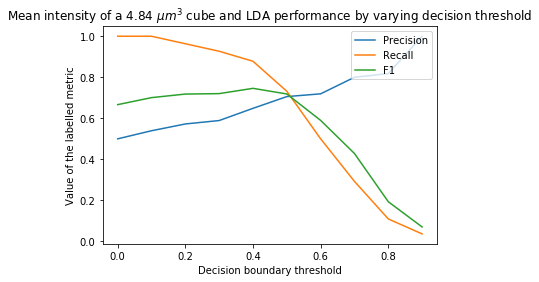

In [95]:
t2, p2, r2, f2 = lda(train2, labels2, test2, shp_2)
stat_plot(t2, p2, r2, f2)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1] Total wrong synapses: 0 Total wrong non-synapses: 95 Precision: 0.5 Recall: 1.0 F1 0.6666666666666666
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1] Total wrong synapses: 0 Total wrong non-synapses: 92 Precision: 0.5080213903743316 Recall: 1.0 F1 0.6737588652482269
[1 1 1 

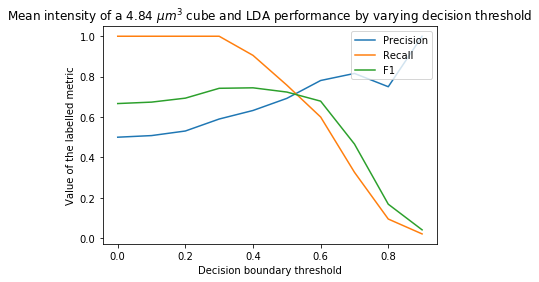

In [96]:
t3, p3, r3, f3 = lda(train3, labels3, test3, shp_3)
stat_plot(t3, p3, r3, f3)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1] Total wrong synapses: 0 Total wrong non-synapses: 98 Precision: 0.5 Recall: 1.0 F1 0.6666666666666666
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0
 1 0 0 0 1 1 1 0 0 1 1] Total wrong synapses: 1 Total wrong non-synapses: 76 Precision: 0.5606936416184971 Recall: 0.9897959

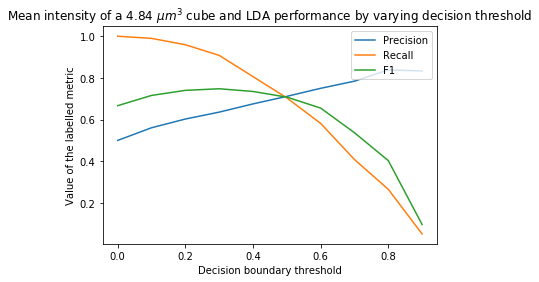

In [97]:
t4, p4, r4, f4 = lda(train4,labels4,test4, shp_4)
stat_plot(t4, p4, r4, f4)

In [22]:
## Running it on timpeoint 1

lda = LDA().fit(train_data, train_labels)
probs_positive_class = lda.predict_proba(test_data)[:,1]

prediction = probs_positive_class > 0.
prediction_int = prediction.astype(int)
print(prediction_int)

NameError: name 'train_data' is not defined

In [ ]:
clf = LDA()
clf.fit(train_data, train_labels)
#predict_proba(test_data)
j = clf.predict(test_data)
print(j)
print(clf.predict_proba(test_data))
print(clf.predict_proba(test_data)[:,1])


In [ ]:
probs_positive_class.shape

In [ ]:
sum(j[148:]) 